In [1]:
!pip install gensim --user --upgrade
# !pip install keras --upgrade
# !pip install pandas --upgrade


Requirement already up-to-date: gensim in c:\users\malah\appdata\roaming\python\python37\site-packages (3.8.1)


You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import gensim
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Malah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data = pd.read_csv("train.csv", encoding="ISO-8859-1", names=["label", "ids", "date", "flag", "user", "text"]) 
data = data.drop(range(1600000)[20000:-20000])

# DATA EXPLORATION

## Dataset details:

#### target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

#### ids: The id of the tweet ( 2087)

#### date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

#### flag: The query (lyx). If there is no query, then this value is NO_QUERY.

#### user: the user that tweeted (robotickilldozr)

#### text: the text of the tweet (Lyx is cool)


In [4]:
print("Dataset size:", len(data))

Dataset size: 40000


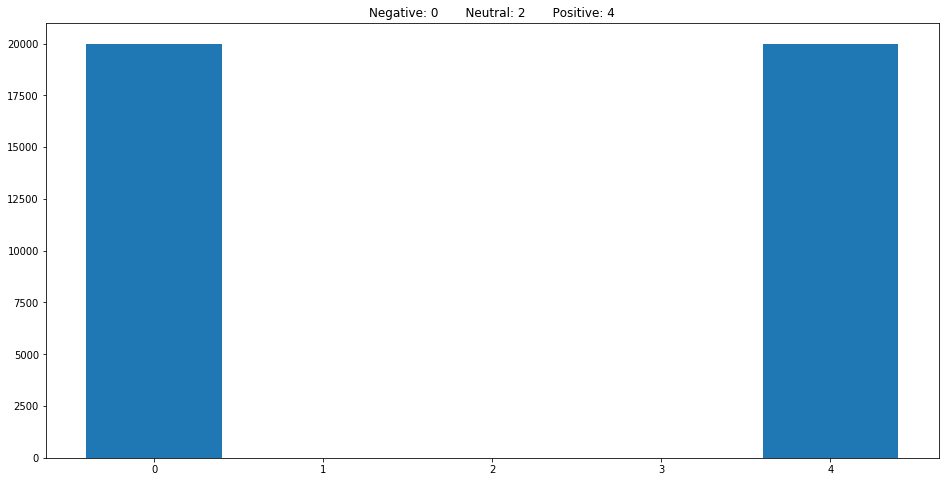

In [5]:
target_cnt = Counter(data.label)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title('''Negative: 0       Neutral: 2       Positive: 4''')
print()

In [6]:
re_clean_symbols = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleanStopWords(sentance):
    sentance = re.sub(re_clean_symbols, ' ', str(sentance).lower()).strip()
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(sentance) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return ' '.join(filtered_sentence)

data.text = data.text.apply(lambda x: cleanStopWords(x))

data.loc[data['label'] == 4]

,label,ids,date,flag,user,text
1580000,4,2190011386,Tue Jun 16 01:30:56 PDT 2009,NO_QUERY,Happysodme,well done old timer getting breakfast pink jim...
1580001,4,2190011394,Tue Jun 16 01:30:56 PDT 2009,NO_QUERY,lovelywings14,haha thanks let know works okay
1580002,4,2190011406,Tue Jun 16 01:30:57 PDT 2009,NO_QUERY,Storm_rider_uk,good morning everyone beautiful morning
1580003,4,2190011433,Tue Jun 16 01:30:57 PDT 2009,NO_QUERY,loveeu4ever,reunited friends imma missed sooo much
1580004,4,2190011510,Tue Jun 16 01:30:58 PDT 2009,NO_QUERY,strybe,something wrong right twitpic lol
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdb com cool hear old walt interviews
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,ready mojo makeover ask details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th birthday boo alll time tupac amaru ...


In [7]:
def countWords(sentences, divider=None):
    word_to_freq = {}
    for sen in sentences:
        for word in sen.split(' '):
            d = 1
            if divider is not None:
                d = divider[word]
            if word not in word_to_freq:
                word_to_freq[word] = 0
            else:
                word_to_freq[word] += 1/d
    return word_to_freq

positive_sentances = data.loc[data['label'] == 4].text
negative_sentances = data.loc[data['label'] == 0].text

words_freq = countWords(data.text)
pos_words_freq = countWords(positive_sentances, words_freq)
neg_words_freq = countWords(negative_sentances, words_freq)

data_to_table = {}
for key in words_freq:
    pos = pos_words_freq[key] if key in pos_words_freq else 0
    neg = neg_words_freq[key] if key in neg_words_freq else 0
    data_to_table[key] = [pos, neg]
    
pd.DataFrame.from_dict(data_to_table, orient='index', columns = ['Positive', 'Negative'])

,Positive,Negative
awww,0.339130,0.652174
bummer,0.106383,0.872340
shoulda,0.000000,0.875000
got,0.443760,0.555680
david,0.619048,0.357143
...,...,...
amaru,0.000000,0.000000
shakur,0.000000,0.000000
thenspcc,0.000000,0.000000
sparkscharity,0.000000,0.000000


# train the model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.2, random_state=43)
print("Train data size:", len(X_train))
print("Test data size:", len(X_test))

Train data size: 32000
Test data size: 8000


In [9]:
doc = [t.split() for t in X_train.text] 
doc

[['would',
  'really',
  'like',
  'good',
  'tracking',
  'info',
  'girlie',
  'easter',
  'dress',
  'sent',
  'usps',
  'tracking',
  'system',
  'stinks'],
 ['route'],
 ['trying',
  'cry',
  'haiir',
  'stupid',
  'gay',
  'ruin',
  'dont',
  'ever',
  'go',
  'eduardo',
  'franco',
  'ever'],
 ['season', '1', 'starting'],
 ['yayyyy', 'glad', 'u', 'loving', 'sleep', 'good'],
 ['damn',
  'joints',
  'sore',
  'moment',
  'either',
  'feeling',
  'effects',
  'pt',
  'session',
  'getting',
  'sick'],
 ['jave',
  'good',
  'night',
  'sleep',
  'epic',
  'failed',
  'group',
  'today',
  'sorry',
  'guys'],
 ['favourite', 'present', 'partly', 'ukulele', 'bilingual', 'means', 'lazy'],
 ['miss', 'online', 'weird', 'seeing', 'online', 'hehehe'],
 ['excited', 'day'],
 ['still',
  'read',
  '9th',
  'amp',
  '10th',
  'princess',
  'diaries',
  'saving',
  'francesca',
  'made',
  'cry',
  'end',
  'hmm',
  'easy',
  'books'],
 ['lmao',
  'think',
  'hands',
  'made',
  'baby',
  'lmao',

In [10]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [11]:
w2v_model